<a href="https://colab.research.google.com/github/CodingLife1024/3D-modelling/blob/main/new_perpl.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import os
from matplotlib import pyplot as plt
import tensorflow as tf
import librosa
import numpy as np
import pandas as pd
from itertools import groupby
import csv
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, Dense, Flatten, MaxPooling2D, Dropout

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
# Define Paths to Files
CAPUCHIN_FILE = os.path.join('/content/drive/MyDrive/data', 'Parsed_Capuchinbird_Clips', 'XC3776-3.wav')
NOT_CAPUCHIN_FILE = os.path.join('/content/drive/MyDrive/data', 'Parsed_Not_Capuchinbird_Clips', 'afternoon-birds-song-in-forest-0.wav')

In [ ]:
def load_wav_16k_mono(filename):
    """Load audio file and resample to 16kHz mono"""
    audio, sr = librosa.load(filename, sr=16000, mono=True)
    return audio

In [ ]:
wave = load_wav_16k_mono(CAPUCHIN_FILE)
nwave = load_wav_16k_mono(NOT_CAPUCHIN_FILE)

In [ ]:
print(wave)
print(wave.shape)

[-0.05156638  0.10698248  0.33992094 ...  0.0407429  -0.00256476
 -0.02162626]
(48000,)


In [ ]:
print(nwave)
print(nwave.shape)

[ 0.          0.          0.         ... -0.00354742 -0.00189032
  0.00252522]
(48928,)


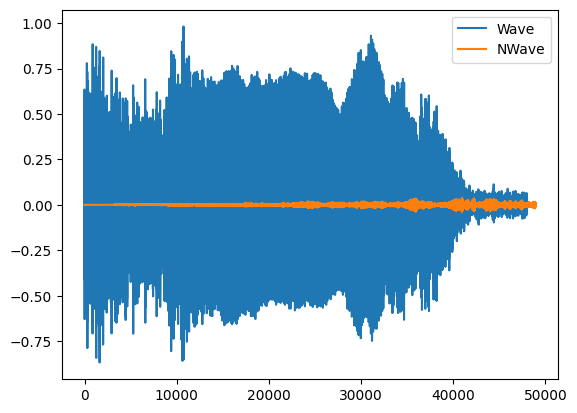

In [ ]:
plt.plot(wave, label='Wave')
plt.plot(nwave, label='NWave')
plt.legend()
plt.show()

In [ ]:
# Create TensorFlow Dataset
POS = os.path.join('/content/drive/MyDrive/data', 'Parsed_Capuchinbird_Clips')
NEG = os.path.join('/content/drive/MyDrive/data', 'Parsed_Not_Capuchinbird_Clips')

In [ ]:
print(os.listdir(POS))  # Check files in the POS directory
print(os.listdir(NEG))  # Check files in the NEG directory

['XC114131-1.wav', 'XC114131-0.wav', 'XC114131-2.wav', 'XC114131-3.wav', 'XC114131-4.wav', 'XC114132-2.wav', 'XC114132-0.wav', 'XC114132-1.wav', 'XC114132-4.wav', 'XC114132-3.wav', 'XC119294-0.wav', 'XC114132-6.wav', 'XC16803-1.wav', 'XC114132-5.wav', 'XC16803-0.wav', 'XC168899-0.wav', 'XC178167-1.wav', 'XC16804-1.wav', 'XC16803-2.wav', 'XC178167-0.wav', 'XC16804-0.wav', 'XC178167-2.wav', 'XC178168-1.wav', 'XC178168-3.wav', 'XC178167-3.wav', 'XC178168-2.wav', 'XC178168-0.wav', 'XC216010-2.wav', 'XC178168-7.wav', 'XC201990-1.wav', 'XC201990-2.wav', 'XC178168-6.wav', 'XC201990-4.wav', 'XC201990-3.wav', 'XC201990-5.wav', 'XC178168-4.wav', 'XC216010-1.wav', 'XC216010-0.wav', 'XC178168-5.wav', 'XC201990-0.wav', 'XC216010-4.wav', 'XC216012-1.wav', 'XC216012-12.wav', 'XC216010-6.wav', 'XC216010-5.wav', 'XC216012-10.wav', 'XC216010-7.wav', 'XC216012-0.wav', 'XC216010-3.wav', 'XC216012-11.wav', 'XC216012-14.wav', 'XC216012-17.wav', 'XC216012-13.wav', 'XC216012-18.wav', 'XC216012-15.wav', 'XC216

In [ ]:
print(POS)
print(NEG)

/content/drive/MyDrive/data/Parsed_Capuchinbird_Clips
/content/drive/MyDrive/data/Parsed_Not_Capuchinbird_Clips


In [ ]:
pos = tf.data.Dataset.list_files(os.path.join(POS, '*.wav'))
neg = tf.data.Dataset.list_files(os.path.join(NEG, '*.wav'))

In [ ]:
positive_spectrograms = []
negative_spectrograms = []

for i in pos:
    wav = load_wav_16k_mono(i.numpy().decode('utf-8'))

    wav = wav[:48000]
    zero_padding = tf.zeros([48000] - tf.shape(wav), dtype=tf.float32)
    wav = tf.concat([wav, zero_padding], 0)
    spectrogram = tf.signal.stft(wav, frame_length=640, frame_step=32)
    spectrogram = tf.abs(spectrogram)
    spectrogram = tf.expand_dims(spectrogram, axis=2)
    positive_spectrograms.append(spectrogram)

for i in neg:
    wav = load_wav_16k_mono(i.numpy().decode('utf-8'))

    wav = wav[:48000]
    zero_padding = tf.zeros([48000] - tf.shape(wav), dtype=tf.float32)
    wav = tf.concat([wav, zero_padding], 0)
    spectrogram = tf.signal.stft(wav, frame_length=640, frame_step=32)
    spectrogram = tf.abs(spectrogram)
    spectrogram = tf.expand_dims(spectrogram, axis=2)
    negative_spectrograms.append(spectrogram)

In [ ]:
pos_labels = [1] * len(positive_spectrograms)
neg_labels = [0] * len(negative_spectrograms)

In [ ]:
data = positive_spectrograms + negative_spectrograms
labels = pos_labels + neg_labels

In [ ]:
dataset = tf.data.Dataset.from_tensor_slices((data, labels))

In [ ]:
buffer_size = len(data)
dataset = dataset.shuffle(buffer_size=buffer_size, seed = 1006)

train_split = 0.8

train_size = int(train_split * len(data))
test_size = len(data) - train_size

train_dataset = dataset.take(train_size)
test_dataset = dataset.skip(train_size)

batch_size = 32
train_dataset = train_dataset.batch(batch_size).prefetch(tf.data.AUTOTUNE)
test_dataset = test_dataset.batch(batch_size).prefetch(tf.data.AUTOTUNE)

In [ ]:
# neg = neg.map(preprocess_2)

In [ ]:
# print(pos)

<_ShuffleDataset element_spec=TensorSpec(shape=(), dtype=tf.string, name=None)>


In [ ]:
# print(neg)

<_ShuffleDataset element_spec=TensorSpec(shape=(), dtype=tf.string, name=None)>


In [ ]:
positives = tf.data.Dataset.zip((pos, tf.data.Dataset.from_tensor_slices(tf.ones(len(pos)))))
negatives = tf.data.Dataset.zip((neg, tf.data.Dataset.from_tensor_slices(tf.zeros(len(neg)))))
data = positives.concatenate(negatives)

In [ ]:
print(positives)

<_ZipDataset element_spec=(TensorSpec(shape=(), dtype=tf.string, name=None), TensorSpec(shape=(), dtype=tf.float32, name=None))>


In [ ]:
negatives

<_ZipDataset element_spec=(TensorSpec(shape=(), dtype=tf.string, name=None), TensorSpec(shape=(), dtype=tf.float32, name=None))>

In [ ]:
data

<_ConcatenateDataset element_spec=(TensorSpec(shape=(), dtype=tf.string, name=None), TensorSpec(shape=(), dtype=tf.float32, name=None))>

In [ ]:
# Calculate average length of Capuchin calls
lengths = []
for file in os.listdir(POS):
    tensor_wave = load_wav_16k_mono(os.path.join(POS, file))
    lengths.append(len(tensor_wave))

In [ ]:
mean_length = tf.math.reduce_mean(lengths)
min_length = tf.math.reduce_min(lengths)
max_length = tf.math.reduce_max(lengths)

In [ ]:
print(mean_length)

tf.Tensor(54156, shape=(), dtype=int32)


In [ ]:
print(min_length)

tf.Tensor(32000, shape=(), dtype=int32)


In [ ]:
print(max_length)

tf.Tensor(80000, shape=(), dtype=int32)


In [ ]:
def preprocess(file_path, label):
    # Convert tensor to string if needed
    # if isinstance(file_path, tf.Tensor):
    #     file_path = file_path.numpy().decode('utf-8')

    # wav = tf.py_function(
    #     load_wav_16k_mono,
    #     [file_path],
    #     tf.float32
    # )

    # Ensure wav has a known shape
    wav = load_wav_16k_mono(file_path)

    wav = wav[:48000]
    zero_padding = tf.zeros([48000] - tf.shape(wav), dtype=tf.float32)
    wav = tf.concat([wav, zero_padding], 0)
    spectrogram = tf.signal.stft(wav, frame_length=320, frame_step=32)
    spectrogram = tf.abs(spectrogram)
    spectrogram = tf.expand_dims(spectrogram, axis=2)
    return spectrogram, label

In [ ]:
filepath, label = positives.shuffle(buffer_size=10000).as_numpy_iterator().next()

In [ ]:
spectrogram, label = preprocess(filepath, label)

In [ ]:
spectrogram

<tf.Tensor: shape=(1491, 257, 1), dtype=float32, numpy=
array([[[3.8263135e-02],
        [7.6380998e-02],
        [1.4749902e-01],
        ...,
        [3.5265555e-05],
        [9.7767233e-06],
        [1.3086945e-05]],

       [[6.9832485e-03],
        [8.4450766e-02],
        [1.5447824e-01],
        ...,
        [3.1338459e-05],
        [3.1159743e-05],
        [2.3189932e-06]],

       [[4.9199596e-02],
        [1.0579010e-01],
        [1.4458527e-01],
        ...,
        [3.4933968e-05],
        [7.5703674e-06],
        [1.0641292e-05]],

       ...,

       [[1.3093978e-02],
        [8.7783057e-03],
        [5.2452706e-02],
        ...,
        [5.5145221e-05],
        [7.3986184e-06],
        [2.7269125e-06]],

       [[6.0230345e-03],
        [2.0940268e-02],
        [4.4599995e-02],
        ...,
        [3.0601637e-05],
        [2.0418769e-05],
        [3.6463141e-05]],

       [[2.1635726e-02],
        [3.1318955e-02],
        [3.3083249e-02],
        ...,
        [4.6313933

In [ ]:
label

1.0

In [ ]:
spectrogram.dtype

tf.float32

In [ ]:
label.dtype

dtype('float32')

In [ ]:
spectrogram.shape

TensorShape([1491, 257, 1])

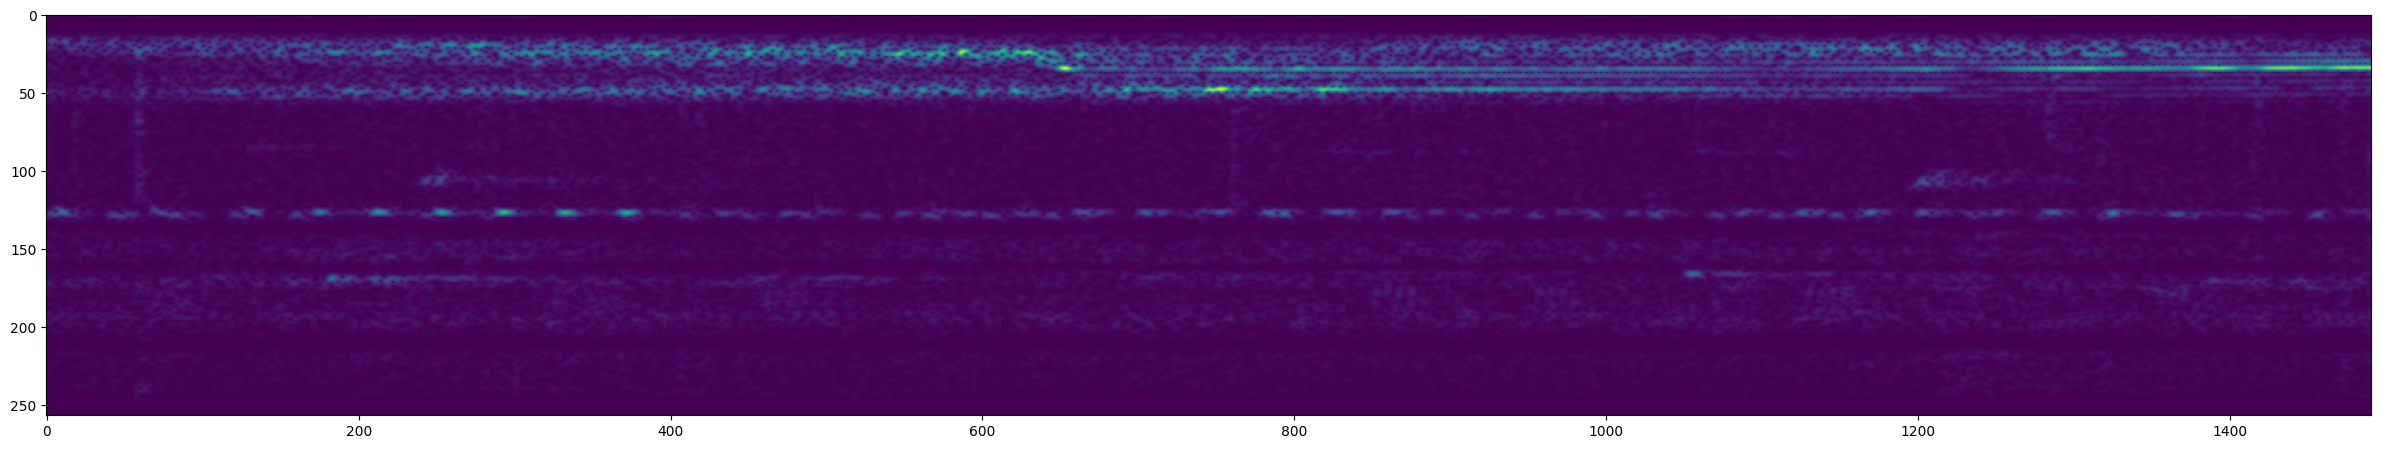

In [ ]:
plt.figure(figsize=(30,20))
plt.imshow(tf.transpose(spectrogram)[0])
plt.show()

In [ ]:
# def decode_and_preprocess(file_path, label):
#     # Decode the file path from tensor to string
#     file_path = file_path.numpy().decode('utf-8')

#     # Now we can use the regular preprocess function
#     return preprocess(file_path, label)

# # Wrap the function to make it compatible with tf.data
# def tf_decode_and_preprocess(file_path, label):
#     # Use tf.py_function to allow numpy operations in dataset pipeline
#     return tf.py_function(
#         decode_and_preprocess,
#         [file_path, label],
#         [tf.float32, tf.float32]  # Adjust these types based on your actual output types
#     )

# # Modified dataset pipeline
# data = data.map(tf_decode_and_preprocess)
# data = data.cache()
# data = data.shuffle(buffer_size=1000)
# data = data.batch(16)
# data = data.prefetch(8)

In [ ]:
len(data)*0.7

567.0

In [ ]:
train = data.take(36)
test = data.skip(36).take(15)

In [ ]:
samples, labels = train.as_numpy_iterator().next()

In [ ]:
samples.shape

(16, 1491, 257, 1)

In [ ]:
labels

array([0., 1., 0., 1., 0., 0., 1., 1., 0., 0., 1., 0., 0., 0., 0., 1.],
      dtype=float32)

In [ ]:
labels.shape

(16,)

In [ ]:
model = Sequential()
model.add(Conv2D(16, (3,3), activation='relu', input_shape=(1491, 257, 1)))
model.add(Conv2D(16, (3,3), activation='relu'))
model.add(Flatten())
model.add(Dense(128, activation='relu'))
model.add(Dense(1, activation='sigmoid'))

/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [ ]:
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                      │ (None, 1489, 255, 16)       │             160 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 1487, 253, 16)       │           2,320 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 6019376)             │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 128)                 │     770,480,256 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 1)                   │             129 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 770,482,865 (2.87 GB)

 Trainable params: 770,482,865 (2.87 GB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
model.compile('Adam', loss='BinaryCrossentropy', metrics=[tf.keras.metrics.Recall(),tf.keras.metrics.Precision()])

In [ ]:
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                      │ (None, 1489, 255, 16)       │             160 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 1487, 253, 16)       │           2,320 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 6019376)             │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 128)                 │     770,480,256 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 1)                   │             129 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 770,482,865 (2.87 GB)

 Trainable params: 770,482,865 (2.87 GB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
for sample_batch, label_batch in train.take(1):
    print("Sample batch shape:", sample_batch.shape)
    print("Label batch shape:", label_batch.shape)


Sample batch shape: (16, 1491, 257, 1)
Label batch shape: (16,)


In [ ]:
samples, labels = train.as_numpy_iterator().next()
print("Train Sample shape:", samples.shape)
print("Train Label shape:", labels.shape)

Train Sample shape: (16, 1491, 257, 1)
Train Label shape: (16,)


In [ ]:
# Fit Model with explicit steps
steps_per_epoch = tf.data.experimental.cardinality(train).numpy()
validation_steps = tf.data.experimental.cardinality(test).numpy()

In [ ]:
steps_per_epoch

36

In [ ]:
validation_steps

15

In [ ]:
# Check shapes before fitting
for sample_batch, label_batch in train.take(1):
    print("Train Sample shape:", sample_batch.shape)
    print("Train Label shape:", label_batch.shape)


Train Sample shape: (16, 1491, 257, 1)
Train Label shape: (16,)


In [ ]:
sample_batch[0]

<tf.Tensor: shape=(1491, 257, 1), dtype=float32, numpy=
array([[[1.18192315e-01],
        [9.40555334e-02],
        [4.34186570e-02],
        ...,
        [1.08058310e-04],
        [2.63479287e-05],
        [4.86373901e-05]],

       [[1.20079041e-01],
        [9.53163654e-02],
        [4.37267087e-02],
        ...,
        [2.23077677e-05],
        [2.90234348e-05],
        [1.80304050e-05]],

       [[1.18078068e-01],
        [9.35420915e-02],
        [4.29414809e-02],
        ...,
        [8.10730635e-05],
        [2.42442711e-05],
        [5.08576632e-05]],

       ...,

       [[6.56395853e-02],
        [5.06677516e-02],
        [2.07981132e-02],
        ...,
        [1.26810526e-04],
        [1.35366310e-04],
        [1.07910484e-04]],

       [[7.23503232e-02],
        [5.50821014e-02],
        [2.11626589e-02],
        ...,
        [9.66691296e-05],
        [1.25767410e-05],
        [4.68492508e-05]],

       [[8.01789984e-02],
        [6.13530166e-02],
        [2.46209502e-02]

In [ ]:

# # Fit Model with explicit steps
# try:
    # hist = model.fit(train, epochs=4, validation_data=test)
model.fit(train_dataset, epochs=4, validation_data=test_dataset)
# except Exception as e:
#     print("Error during model fitting:", e)

Epoch 1/4


ValueError: Creating variables on a non-first call to a function decorated with tf.function.

In [ ]:
data

<_PrefetchDataset element_spec=(TensorSpec(shape=<unknown>, dtype=tf.float32, name=None), TensorSpec(shape=<unknown>, dtype=tf.float32, name=None))>

In [ ]:
hist = model.fit(train, epochs=4, validation_data=test)

Epoch 1/4


ValueError: Exception encountered when calling Sequential.call().

[1mCannot take the length of shape with unknown rank.[0m

Arguments received by Sequential.call():
  • inputs=tf.Tensor(shape=<unknown>, dtype=float32)
  • training=True
  • mask=None

In [ ]:
training_loss = hist.history['loss']
validation_loss = hist.history['val_loss']

NameError: name 'hist' is not defined

NameError: name 'hist' is not defined

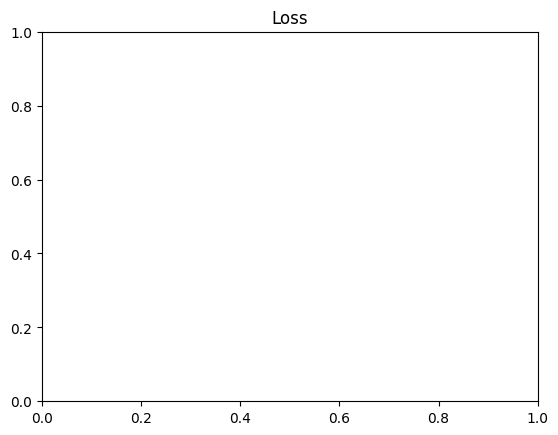

In [ ]:
plt.title('Loss')
plt.plot(hist.history['loss'], 'r')
plt.plot(hist.history['val_loss'], 'b')
plt.show()

NameError: name 'hist' is not defined

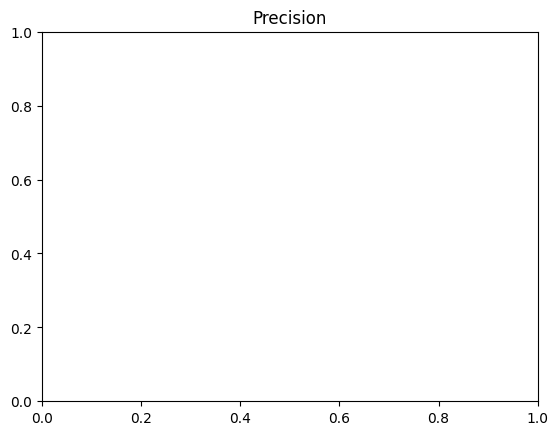

In [ ]:
plt.title('Precision')
plt.plot(hist.history['precision'], 'r')
plt.plot(hist.history['val_precision'], 'b')
plt.show()

NameError: name 'hist' is not defined

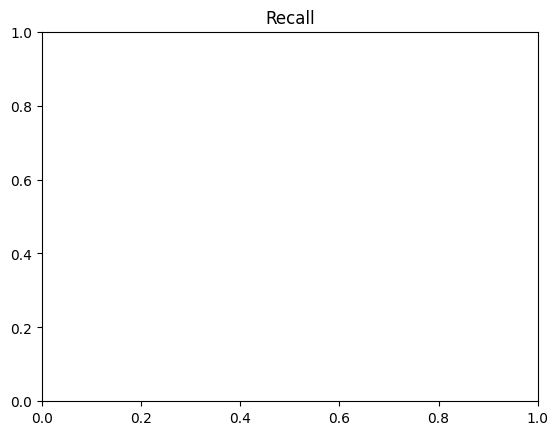

In [ ]:
plt.title('Recall')
plt.plot(hist.history['recall'], 'r')
plt.plot(hist.history['val_recall'], 'b')
plt.show()

In [ ]:
X_test, y_test = test.as_numpy_iterator().next()

In [ ]:
yhat = model.predict(X_test)

1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step


In [ ]:
yhat = [1 if prediction > 0.5 else 0 for prediction in yhat]

In [ ]:
def load_mp3_16k_mono(filename):
    """ Load a WAV file, convert it to a float tensor, resample to 16 kHz single-channel audio. """
    wav, _ = librosa.load(filename, sr=16000, mono=True)
    return wav

In [ ]:
mp3 = os.path.join('/content/drive/MyDrive/data', 'Forest Recordings', 'recording_00.mp3')

In [ ]:
wav = load_mp3_16k_mono(mp3)

In [ ]:
audio_slices = tf.keras.utils.timeseries_dataset_from_array(wav, wav, sequence_length=48000, sequence_stride=48000, batch_size=1)

In [ ]:
samples, index = audio_slices.as_numpy_iterator().next()

In [ ]:
def preprocess_mp3(sample, index):
    sample = sample[0]
    zero_padding = tf.zeros([48000] - tf.shape(sample), dtype=tf.float32)
    wav = tf.concat([zero_padding, sample],0)
    spectrogram = tf.signal.stft(wav, frame_length=320, frame_step=32)
    spectrogram = tf.abs(spectrogram)
    spectrogram = tf.expand_dims(spectrogram, axis=2)
    return spectrogram

In [ ]:
audio_slices = tf.keras.utils.timeseries_dataset_from_array(wav, wav, sequence_length=16000, sequence_stride=16000, batch_size=1)
audio_slices = audio_slices.map(preprocess_mp3)
audio_slices = audio_slices.batch(64)

In [ ]:
yhat = model.predict(audio_slices)
yhat = [1 if prediction > 0.5 else 0 for prediction in yhat]

3/3 ━━━━━━━━━━━━━━━━━━━━ 42s 14s/step


In [ ]:
yhat = [key for key, group in groupby(yhat)]
calls = tf.math.reduce_sum(yhat).numpy()

In [ ]:
calls

17

In [ ]:
results = {}
for file in os.listdir(os.path.join('/content/drive/MyDrive/data', 'Forest Recordings')):
    FILEPATH = os.path.join('/content/drive/MyDrive/data','Forest Recordings', file)

    wav = load_mp3_16k_mono(FILEPATH)
    audio_slices = tf.keras.utils.timeseries_dataset_from_array(wav, wav, sequence_length=48000, sequence_stride=48000, batch_size=1)
    audio_slices = audio_slices.map(preprocess_mp3)
    audio_slices = audio_slices.batch(64)

    yhat = model.predict(audio_slices)

    results[file] = yhat

1/1 ━━━━━━━━━━━━━━━━━━━━ 11s 11s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 11s 11s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 12s 12s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 9s 9s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 11s 11s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 12s 12s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 9s 9s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 11s 11s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 12s 12s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 9s 9s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 11s 11s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 12s 12s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 9s 9s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 10s 10s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 11s 11s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 10s 10s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 10s 10s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 12s 12s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 11s 11s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 9s 9s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 11s 11s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 13s 13s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 9s 9s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 11s 11s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 13s 13s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 9s 9s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1

In [ ]:
results

{'recording_00.mp3': array([[0.5114661 ],
        [0.50651646],
        [0.5136313 ],
        [0.48184863],
        [0.46602112],
        [0.5039638 ],
        [0.50492907],
        [0.50373137],
        [0.51290774],
        [0.5029638 ],
        [0.50555116],
        [0.5054848 ],
        [0.5030006 ],
        [0.5039551 ],
        [0.46777368],
        [0.51216733],
        [0.49906674],
        [0.50400686],
        [0.50498164],
        [0.51165485],
        [0.5027635 ],
        [0.50771075],
        [0.5086884 ],
        [0.5029379 ],
        [0.4570662 ],
        [0.51815456],
        [0.50513196],
        [0.50754476],
        [0.5103755 ],
        [0.50746846],
        [0.5047553 ],
        [0.507901  ],
        [0.49895573],
        [0.5167547 ],
        [0.5041333 ],
        [0.49662718],
        [0.485721  ],
        [0.51221454],
        [0.504859  ],
        [0.5026345 ],
        [0.50366855],
        [0.51634645],
        [0.50849724],
        [0.5075773 ],
        [0.5

In [ ]:
class_preds = {}
for file, logits in results.items():
    class_preds[file] = [1 if prediction > 0.55 else 0 for prediction in logits]
class_preds

{'recording_00.mp3': [0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0],
 'recording_01.mp3': [0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  1,
  0,
  0,
  0],
 'recording_02.mp3': [0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  1,
  0,
  1,
  0,
  0,
  0,
  0,
  1,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  1,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  1,
  0,
  0,
  0],
 'recording_03.mp3': [0,
  0,
  0,
  

In [ ]:
postprocessed = {}
for file, scores in class_preds.items():
    postprocessed[file] = tf.math.reduce_sum([key for key, group in groupby(scores)]).numpy()
postprocessed

{'recording_00.mp3': 0,
 'recording_01.mp3': 1,
 'recording_02.mp3': 5,
 'recording_03.mp3': 4,
 'recording_04.mp3': 0,
 'recording_05.mp3': 0,
 'recording_06.mp3': 0,
 'recording_07.mp3': 1,
 'recording_08.mp3': 0,
 'recording_09.mp3': 0,
 'recording_10.mp3': 0,
 'recording_11.mp3': 0,
 'recording_12.mp3': 9,
 'recording_13.mp3': 0,
 'recording_14.mp3': 0,
 'recording_15.mp3': 4,
 'recording_16.mp3': 0,
 'recording_17.mp3': 1,
 'recording_18.mp3': 3,
 'recording_19.mp3': 0,
 'recording_20.mp3': 12,
 'recording_21.mp3': 9,
 'recording_22.mp3': 0,
 'recording_23.mp3': 0,
 'recording_26.mp3': 0,
 'recording_25.mp3': 2,
 'recording_27.mp3': 0,
 'recording_24.mp3': 0,
 'recording_28.mp3': 6,
 'recording_29.mp3': 13,
 'recording_31.mp3': 0,
 'recording_30.mp3': 10,
 'recording_32.mp3': 0,
 'recording_34.mp3': 0,
 'recording_35.mp3': 0,
 'recording_33.mp3': 0,
 'recording_38.mp3': 0,
 'recording_36.mp3': 15,
 'recording_37.mp3': 0,
 'recording_41.mp3': 1,
 'recording_42.mp3': 0,
 'recording_

In [ ]:
with open('/content/drive/MyDrive/data/results.csv', 'w', newline='') as f:
    print(os.path.exists('/content/drive/MyDrive/data/results.csv'))
    writer = csv.writer(f, delimiter=',')
    writer.writerow(['recording', 'capuchin_calls'])
    for key, value in postprocessed.items():
        writer.writerow([key, value])
        print(key, value)

True
recording_00.mp3 0
recording_01.mp3 1
recording_02.mp3 5
recording_03.mp3 4
recording_04.mp3 0
recording_05.mp3 0
recording_06.mp3 0
recording_07.mp3 1
recording_08.mp3 0
recording_09.mp3 0
recording_10.mp3 0
recording_11.mp3 0
recording_12.mp3 9
recording_13.mp3 0
recording_14.mp3 0
recording_15.mp3 4
recording_16.mp3 0
recording_17.mp3 1
recording_18.mp3 3
recording_19.mp3 0
recording_20.mp3 12
recording_21.mp3 9
recording_22.mp3 0
recording_23.mp3 0
recording_26.mp3 0
recording_25.mp3 2
recording_27.mp3 0
recording_24.mp3 0
recording_28.mp3 6
recording_29.mp3 13
recording_31.mp3 0
recording_30.mp3 10
recording_32.mp3 0
recording_34.mp3 0
recording_35.mp3 0
recording_33.mp3 0
recording_38.mp3 0
recording_36.mp3 15
recording_37.mp3 0
recording_41.mp3 1
recording_42.mp3 0
recording_39.mp3 1
recording_40.mp3 0
recording_43.mp3 0
recording_44.mp3 0
recording_46.mp3 1
recording_45.mp3 1
recording_48.mp3 0
recording_47.mp3 5
recording_51.mp3 0
recording_49.mp3 0
recording_50.mp3 0
rec